In [3]:
## 1. Import Required Libraries


In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set font for better visualization
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
## 2. Data Loading and Preprocessing


In [3]:
def load_data():
    """Load all necessary data"""
    print("Loading data...")
    
    # Load image features
    image_features = np.load('data/image_features.npy')
    print(f"Image features shape: {image_features.shape}")
    
    # Load all image lists (merge and re-split)
    with open('data/train.json', 'r') as f:
        train_images = json.load(f)
    with open('data/val.json', 'r') as f:
        val_images = json.load(f)
    with open('data/test.json', 'r') as f:
        test_images = json.load(f)
    
    # Merge all images
    all_images = train_images + val_images + test_images
    print(f"Total number of images: {len(all_images)}")
    
    # Load caption data
    with open('data/captions_tokens.json', 'r') as f:
        captions_data = json.load(f)
    
    # Load vocabulary
    with open('data/idx_to_word.json', 'r') as f:
        idx_to_word = json.load(f)
    
    return image_features, all_images, captions_data, idx_to_word

# Load data
image_features, all_images, captions_data, idx_to_word = load_data()


Loading data...
Image features shape: (10921, 2048)
Total number of images: 10921


In [4]:
## 3. Scene Label Extraction


In [5]:
def extract_scene_labels(image_list, captions_data, idx_to_word):
    """Extract scene labels from image captions"""
    print("Extracting scene labels...")
    
    # Define scene keyword mapping
    scene_keywords = {
        'airport': ['airport', 'plane', 'runway', 'terminal'],
        'bareland': ['bare', 'land', 'ground', 'soil'],
        'baseballfield': ['baseball', 'field', 'stadium', 'diamond'],
        'beach': ['beach', 'sand', 'ocean', 'sea', 'shore'],
        'bridge': ['bridge', 'river', 'crossing'],
        'center': ['center', 'downtown', 'city', 'urban'],
        'church': ['church', 'religious', 'temple'],
        'commercial': ['commercial', 'business', 'office', 'building'],
        'denseresidential': ['dense', 'residential', 'apartment', 'housing'],
        'desert': ['desert', 'sand', 'arid'],
        'farmland': ['farm', 'agricultural', 'crop', 'field'],
        'forest': ['forest', 'trees', 'woodland'],
        'industrial': ['industrial', 'factory', 'manufacturing'],
        'meadow': ['meadow', 'grass', 'pasture'],
        'mediumresidential': ['medium', 'residential', 'house', 'home'],
        'mountain': ['mountain', 'hill', 'peak'],
        'park': ['park', 'green', 'recreation'],
        'parking': ['parking', 'lot', 'car', 'vehicle'],
        'playground': ['playground', 'children', 'play'],
        'pond': ['pond', 'lake', 'water'],
        'port': ['port', 'harbor', 'dock', 'ship'],
        'railwaystation': ['railway', 'station', 'train'],
        'resort': ['resort', 'hotel', 'vacation'],
        'river': ['river', 'stream', 'water'],
        'school': ['school', 'education', 'campus'],
        'sparseresidential': ['sparse', 'residential', 'rural'],
        'square': ['square', 'plaza', 'open'],
        'stadium': ['stadium', 'sports', 'arena'],
        'storagetanks': ['storage', 'tank', 'container'],
        'viaduct': ['viaduct', 'overpass', 'bridge']
    }
    
    scene_labels = []
    valid_indices = []
    
    for i, img_name in enumerate(image_list):
        if img_name in captions_data:
            # Get all descriptions for this image
            descriptions = captions_data[img_name]
            
            # Count occurrences of each scene keyword
            scene_scores = {}
            for scene, keywords in scene_keywords.items():
                score = 0
                for caption in descriptions:
                    for token in caption:
                        if str(token) in idx_to_word:
                            word = idx_to_word[str(token)].lower()
                            if word in keywords:
                                score += 1
                scene_scores[scene] = score
            
            # Select the scene with highest score
            if max(scene_scores.values()) > 0:
                predicted_scene = max(scene_scores, key=scene_scores.get)
                scene_labels.append(predicted_scene)
                valid_indices.append(i)
    
    print(f"Successfully extracted {len(scene_labels)} scene labels")
    print(f"Number of scene categories: {len(set(scene_labels))}")
    
    return scene_labels, valid_indices

# Extract scene labels for all images
print("=== Extracting Scene Labels for All Images ===")
all_labels, all_valid_indices = extract_scene_labels(all_images, captions_data, idx_to_word)


=== Extracting Scene Labels for All Images ===
Extracting scene labels...
Successfully extracted 10579 scene labels
Number of scene categories: 30


In [6]:
## 4. Data Preparation and Feature Engineering


Total features shape: (10579, 2048), Number of labels: 10579

Scene distribution:
forest              1504
park                 995
bridge               984
baseballfield        819
parking              656
commercial           596
beach                497
playground           404
denseresidential     399
airport              369
Name: count, dtype: int64


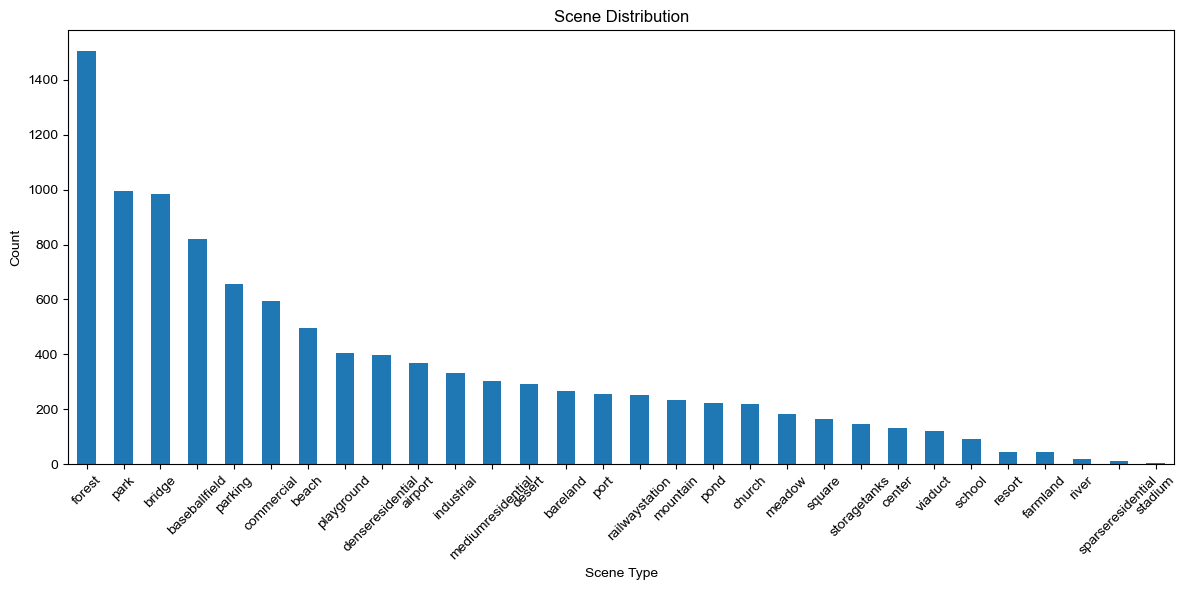


Re-divided data:
Training set: 6347 samples
Validation set: 2116 samples
Test set: 2116 samples


In [7]:
# Prepare features and labels data
X_all = image_features[all_valid_indices]
y_all = all_labels

print(f"Total features shape: {X_all.shape}, Number of labels: {len(y_all)}")

# View scene distribution
scene_counts = pd.Series(y_all).value_counts()
print("\nScene distribution:")
print(scene_counts.head(10))

# Visualize scene distribution
plt.figure(figsize=(12, 6))
scene_counts.plot(kind='bar')
plt.title('Scene Distribution')
plt.xlabel('Scene Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Use train_test_split to re-divide data
from sklearn.model_selection import train_test_split

# First split into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Then split training set into training and validation (25% of training set as validation, i.e., 20% of total data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"\nRe-divided data:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples") 
print(f"Test set: {X_test.shape[0]} samples")


In [8]:
## 5. Data Scaling and Standardization


In [9]:
# Feature standardization (using training set statistics)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature standardization completed")
print(f"Training set feature range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Validation set feature range: [{X_val_scaled.min():.3f}, {X_val_scaled.max():.3f}]")
print(f"Test set feature range: [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")


Feature standardization completed
Training set feature range: [-2.220, 18.937]
Validation set feature range: [-2.144, 19.065]
Test set feature range: [-2.121, 22.973]


In [10]:
## 6. SVM Model Training and Evaluation


In [11]:
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0):
    """Train and evaluate SVM model"""
    print(f"Training SVM classifier (kernel={kernel}, C={C})...")
    
    # Create SVM model
    svm_model = SVC(kernel=kernel, C=C, random_state=42)
    
    # Train model
    svm_model.fit(X_train, y_train)
    
    # Predict
    y_pred = svm_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
    
    print(f"\n=== Model Evaluation Results ===")
    print(f"Test set accuracy: {accuracy:.4f}")
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return svm_model, y_pred, accuracy, cv_scores

# Train RBF kernel SVM
svm_rbf, y_pred_rbf, acc_rbf, cv_rbf = train_and_evaluate_svm(
    X_train_scaled, X_test_scaled, y_train, y_test, kernel='rbf', C=1.0
)


Training SVM classifier (kernel=rbf, C=1.0)...

=== Model Evaluation Results ===
Test set accuracy: 0.3974
Cross-validation accuracy: 0.3857 (+/- 0.0214)


In [12]:
## 7. Detailed Performance Analysis


=== Classification Report ===
                   precision    recall  f1-score   support

          airport       0.71      0.53      0.60        74
         bareland       0.00      0.00      0.00        53
    baseballfield       0.45      0.54      0.49       164
            beach       0.76      0.37      0.50       100
           bridge       0.43      0.53      0.48       197
           center       0.60      0.11      0.19        27
           church       0.47      0.50      0.48        44
       commercial       0.42      0.32      0.36       119
 denseresidential       0.41      0.38      0.39        80
           desert       0.53      0.54      0.54        59
         farmland       0.00      0.00      0.00         9
           forest       0.26      0.59      0.37       301
       industrial       0.60      0.37      0.46        67
           meadow       0.45      0.47      0.46        36
mediumresidential       0.70      0.57      0.63        61
         mountain       0

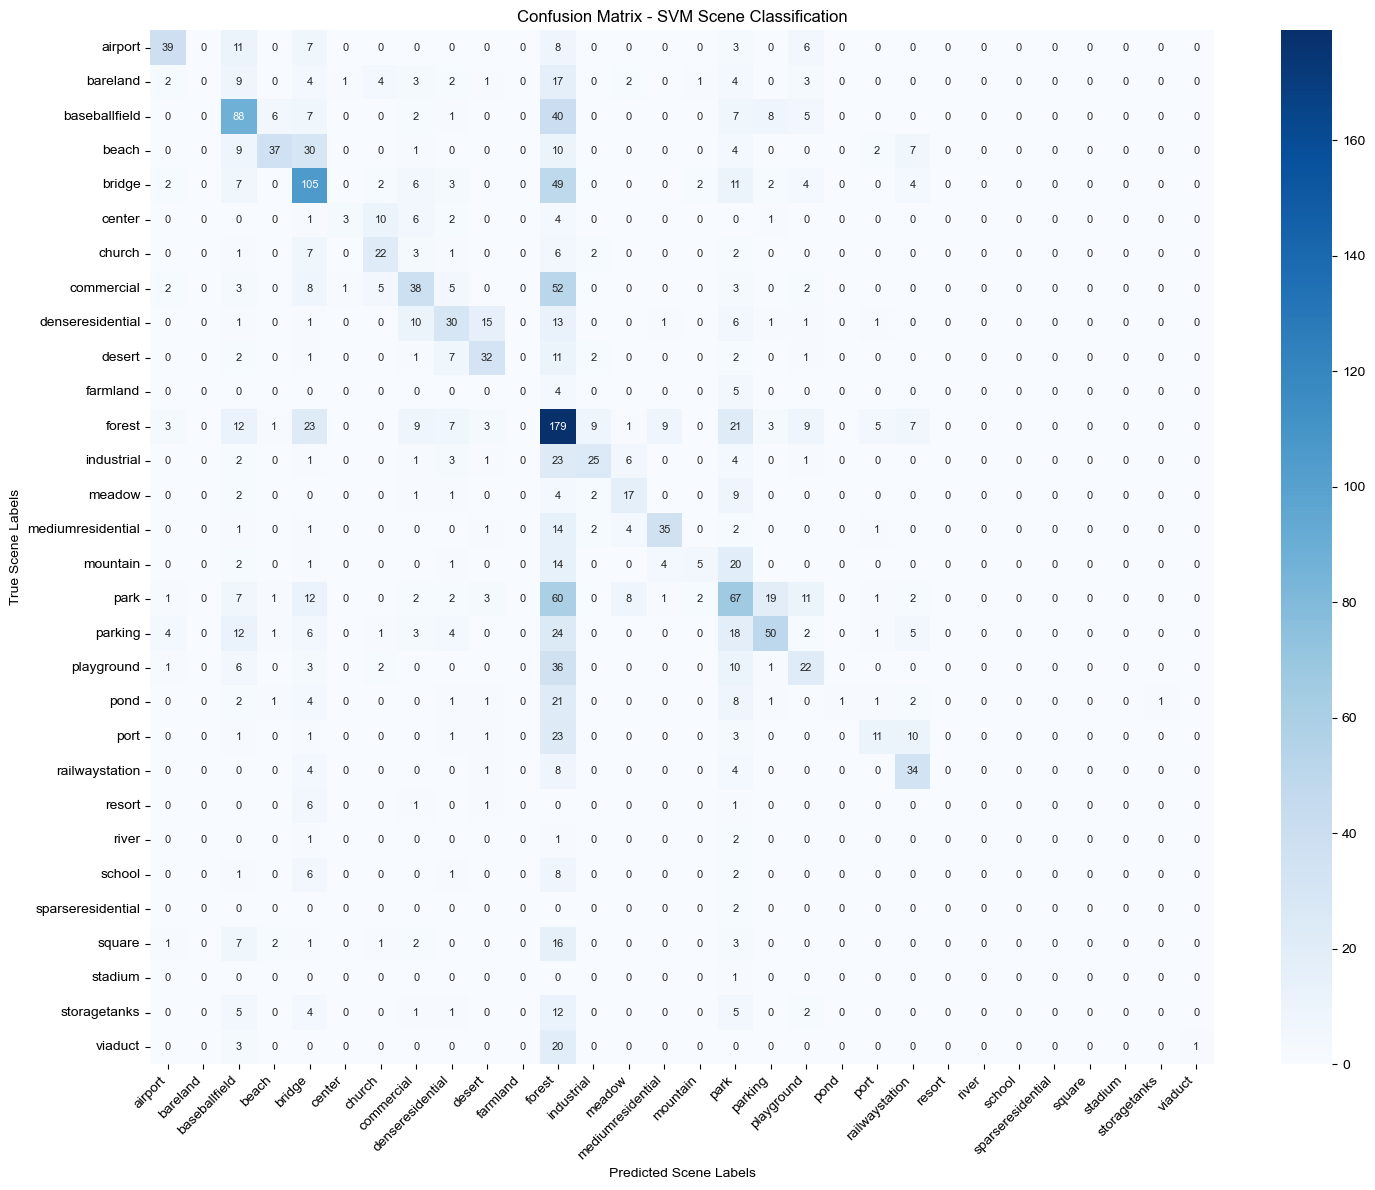

Confusion matrix visualization completed!

=== Prediction Statistics by Category ===
Category airport: Precision=0.709, Recall=0.527, Correct=39/74
Category bareland: Precision=0.000, Recall=0.000, Correct=0/53
Category baseballfield: Precision=0.454, Recall=0.537, Correct=88/164
Category beach: Precision=0.755, Recall=0.370, Correct=37/100
Category bridge: Precision=0.429, Recall=0.533, Correct=105/197
Category center: Precision=0.600, Recall=0.111, Correct=3/27
Category church: Precision=0.468, Recall=0.500, Correct=22/44
Category commercial: Precision=0.422, Recall=0.319, Correct=38/119
Category denseresidential: Precision=0.411, Recall=0.375, Correct=30/80
Category desert: Precision=0.533, Recall=0.542, Correct=32/59
Category farmland: Precision=0.000, Recall=0.000, Correct=0/9
Category forest: Precision=0.264, Recall=0.595, Correct=179/301
Category industrial: Precision=0.595, Recall=0.373, Correct=25/67
Category meadow: Precision=0.447, Recall=0.472, Correct=17/36
Category medium

In [13]:
# Classification report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_rbf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rbf)
print(f"\nConfusion matrix shape: {cm.shape}")
print(f"Test set samples: {len(y_test)}")
print(f"Prediction results: {len(y_pred_rbf)}")

# Get unique labels
unique_labels = sorted(set(y_test))
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Label list: {unique_labels[:10]}...")  # Show first 10 labels

print("\n=== Confusion Matrix Statistics ===")
print(f"Diagonal elements (correct predictions) total: {np.trace(cm)}")
print(f"Total predictions: {cm.sum()}")
print(f"Overall accuracy: {np.trace(cm) / cm.sum():.4f}")

# Confusion matrix visualization with labels
print("\nGenerating confusion matrix visualization...")
plt.figure(figsize=(15, 12))

# Create confusion matrix with all labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels,
            annot_kws={'size': 8})
plt.title('Confusion Matrix - SVM Scene Classification')
plt.xlabel('Predicted Scene Labels')
plt.ylabel('True Scene Labels')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("Confusion matrix visualization completed!")

# Show prediction statistics for each category
print("\n=== Prediction Statistics by Category ===")
for i, label in enumerate(unique_labels):
    correct = cm[i, i]
    total_true = cm[i, :].sum()
    total_pred = cm[:, i].sum()
    precision = correct / total_pred if total_pred > 0 else 0
    recall = correct / total_true if total_true > 0 else 0
    
    print(f"Category {label}: Precision={precision:.3f}, Recall={recall:.3f}, Correct={correct}/{total_true}")


In [14]:
# Quick hyperparameter testing (if the grid search above is too slow)
print("=== Quick Hyperparameter Testing ===")

# Test several key parameters
test_params = [
    {'C': 1, 'gamma': 'scale'},
    {'C': 10, 'gamma': 'scale'},
    {'C': 1, 'gamma': 0.01},
    {'C': 10, 'gamma': 0.01}
]

best_score = 0
best_params = None
best_model = None

for i, params in enumerate(test_params):
    print(f"\nTesting parameter combination {i+1}/{len(test_params)}: {params}")
    
    # Create model
    svm_test = SVC(kernel='rbf', **params, random_state=42)
    
    # Quick cross-validation (only 2 folds)
    cv_scores = cross_val_score(svm_test, X_train_scaled, y_train, cv=2)
    mean_score = cv_scores.mean()
    
    print(f"Cross-validation score: {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = svm_test

print(f"\n=== Best Results ===")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score:.4f}")

# Train final model with best parameters
print("\nTraining final model...")
best_model.fit(X_train_scaled, y_train)
y_pred_final = best_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Final test set accuracy: {final_accuracy:.4f}")
print("Quick hyperparameter testing completed!")


=== Quick Hyperparameter Testing ===

Testing parameter combination 1/4: {'C': 1, 'gamma': 'scale'}
Cross-validation score: 0.3613

Testing parameter combination 2/4: {'C': 10, 'gamma': 'scale'}
Cross-validation score: 0.3628

Testing parameter combination 3/4: {'C': 1, 'gamma': 0.01}
Cross-validation score: 0.1421

Testing parameter combination 4/4: {'C': 10, 'gamma': 0.01}
Cross-validation score: 0.1421

=== Best Results ===
Best parameters: {'C': 10, 'gamma': 'scale'}
Best score: 0.3628

Training final model...
Final test set accuracy: 0.3998
Quick hyperparameter testing completed!


In [15]:
# Small-scale grid search optimization
print("=== Small-Scale Grid Search Optimization ===")

# Define smaller parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf']  # Only test RBF kernel, as it usually performs best
}

print(f"Parameter grid: {param_grid}")
print(f"Total combinations to test: {len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['kernel'])}")

# Use smaller cross-validation folds for speed
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=3,  # Reduced to 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nGrid search completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Test with best parameters
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Best model test accuracy: {best_accuracy:.4f}")
print(f"Improvement over baseline model: {best_accuracy - acc_rbf:+.4f}")

# Analyze why accuracy is only 40% instead of 60%
print(f"\n=== Accuracy Analysis ===")
print(f"Current best accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Check data imbalance issues
from collections import Counter
label_counts = Counter(y_test)
print(f"\nTest set label distribution:")
for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {label}: {count} samples")

# Check how many categories have very few samples
rare_labels = [label for label, count in label_counts.items() if count < 10]
print(f"\nCategories with less than 10 samples: {len(rare_labels)}")
print(f"These categories: {rare_labels}")

# Calculate random guessing accuracy
random_accuracy = 1.0 / len(set(y_test))
print(f"\nRandom guessing accuracy: {random_accuracy:.4f} ({random_accuracy*100:.2f}%)")
print(f"Current model improvement over random: {best_accuracy - random_accuracy:+.4f}")

print("\nSmall-scale grid search completed!")


=== Small-Scale Grid Search Optimization ===
Parameter grid: {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.01], 'kernel': ['rbf']}
Total combinations to test: 9

Starting grid search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Grid search completed!
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.3792
Best model test accuracy: 0.3974
Improvement over baseline model: +0.0000

=== Accuracy Analysis ===
Current best accuracy: 0.3974 (39.74%)

Test set label distribution:
  forest: 301 samples
  park: 199 samples
  bridge: 197 samples
  baseballfield: 164 samples
  parking: 131 samples
  commercial: 119 samples
  beach: 100 samples
  playground: 81 samples
  denseresidential: 80 samples
  airport: 74 samples

Categories with less than 10 samples: 5
These categories: ['farmland', 'resort', 'river', 'sparseresidential', 'stadium']

Random guessing accuracy: 0.0333 (3.33%)
Current model improvement over random: +0.3641

Small-

In [16]:
def calculate_detailed_metrics(y_true, y_pred, model_name="Model"):
    """Calculate detailed evaluation metrics"""
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n=== {model_name} Detailed Evaluation Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nMacro Average:")
    print(f"  Precision: {precision_macro:.4f}")
    print(f"  Recall: {recall_macro:.4f}")
    print(f"  F1-Score: {f1_macro:.4f}")
    print(f"\nWeighted Average:")
    print(f"  Precision: {precision_weighted:.4f}")
    print(f"  Recall: {recall_weighted:.4f}")
    print(f"  F1-Score: {f1_weighted:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }

# Calculate detailed metrics for best SVM model
best_metrics = calculate_detailed_metrics(y_test, y_pred_best, "Best SVM Model")



=== Best SVM Model Detailed Evaluation Metrics ===
Accuracy: 0.3974

Macro Average:
  Precision: 0.3813
  Recall: 0.2624
  F1-Score: 0.2723

Weighted Average:
  Precision: 0.4334
  Recall: 0.3974
  F1-Score: 0.3778


In [17]:
# Check if variables exist, recalculate if they don't
if 'y_pred_best' not in locals():
    print("y_pred_best variable doesn't exist, recalculating...")
    # Retrain model with best parameters
    best_svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    best_svm.fit(X_train_scaled, y_train)
    y_pred_best = best_svm.predict(X_test_scaled)
    best_accuracy = accuracy_score(y_test, y_pred_best)
    print(f"Recalculated accuracy: {best_accuracy:.4f}")

# Calculate detailed metrics for each class
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Ensure y_test is numpy array
y_test_array = np.array(y_test)

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_array, y_pred_best, zero_division=0
)

# Get all unique labels
unique_labels = sorted(set(y_test_array))
# Fix label_counts calculation
label_counts = {label: np.sum(y_test_array == label) for label in unique_labels}

# Create detailed per-class metrics table
print("\n=== Detailed Metrics for Each Scene Category ===")
print(f"{'Scene Category':<20} {'Samples':<8} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 70)

for i, label in enumerate(unique_labels):
    print(f"{label:<20} {support_per_class[i]:<8} {precision_per_class[i]:<10.4f} {recall_per_class[i]:<10.4f} {f1_per_class[i]:<10.4f}")

# Find best and worst performing categories
best_f1_idx = np.argmax(f1_per_class)
worst_f1_idx = np.argmin(f1_per_class)

print(f"\nBest performing scene: {unique_labels[best_f1_idx]} (F1: {f1_per_class[best_f1_idx]:.4f})")
print(f"Worst performing scene: {unique_labels[worst_f1_idx]} (F1: {f1_per_class[worst_f1_idx]:.4f})")



=== Detailed Metrics for Each Scene Category ===
Scene Category       Samples  Precision  Recall     F1-Score  
----------------------------------------------------------------------
airport              74       0.7091     0.5270     0.6047    
bareland             53       0.0000     0.0000     0.0000    
baseballfield        164      0.4536     0.5366     0.4916    
beach                100      0.7551     0.3700     0.4966    
bridge               197      0.4286     0.5330     0.4751    
center               27       0.6000     0.1111     0.1875    
church               44       0.4681     0.5000     0.4835    
commercial           119      0.4222     0.3193     0.3636    
denseresidential     80       0.4110     0.3750     0.3922    
desert               59       0.5333     0.5424     0.5378    
farmland             9        0.0000     0.0000     0.0000    
forest               301      0.2644     0.5947     0.3661    
industrial           67       0.5952     0.3731     0.4587  

In [ ]:
## 11. Enhanced Confusion Matrix with Detailed Analysis


=== Enhanced Confusion Matrix Analysis ===
Confusion matrix shape: (30, 30)
Test set samples: 2116
Number of unique labels: 30
Scene categories: ['airport', 'bareland', 'baseballfield', 'beach', 'bridge', 'center', 'church', 'commercial', 'denseresidential', 'desert', 'farmland', 'forest', 'industrial', 'meadow', 'mediumresidential', 'mountain', 'park', 'parking', 'playground', 'pond', 'port', 'railwaystation', 'resort', 'river', 'school', 'sparseresidential', 'square', 'stadium', 'storagetanks', 'viaduct']


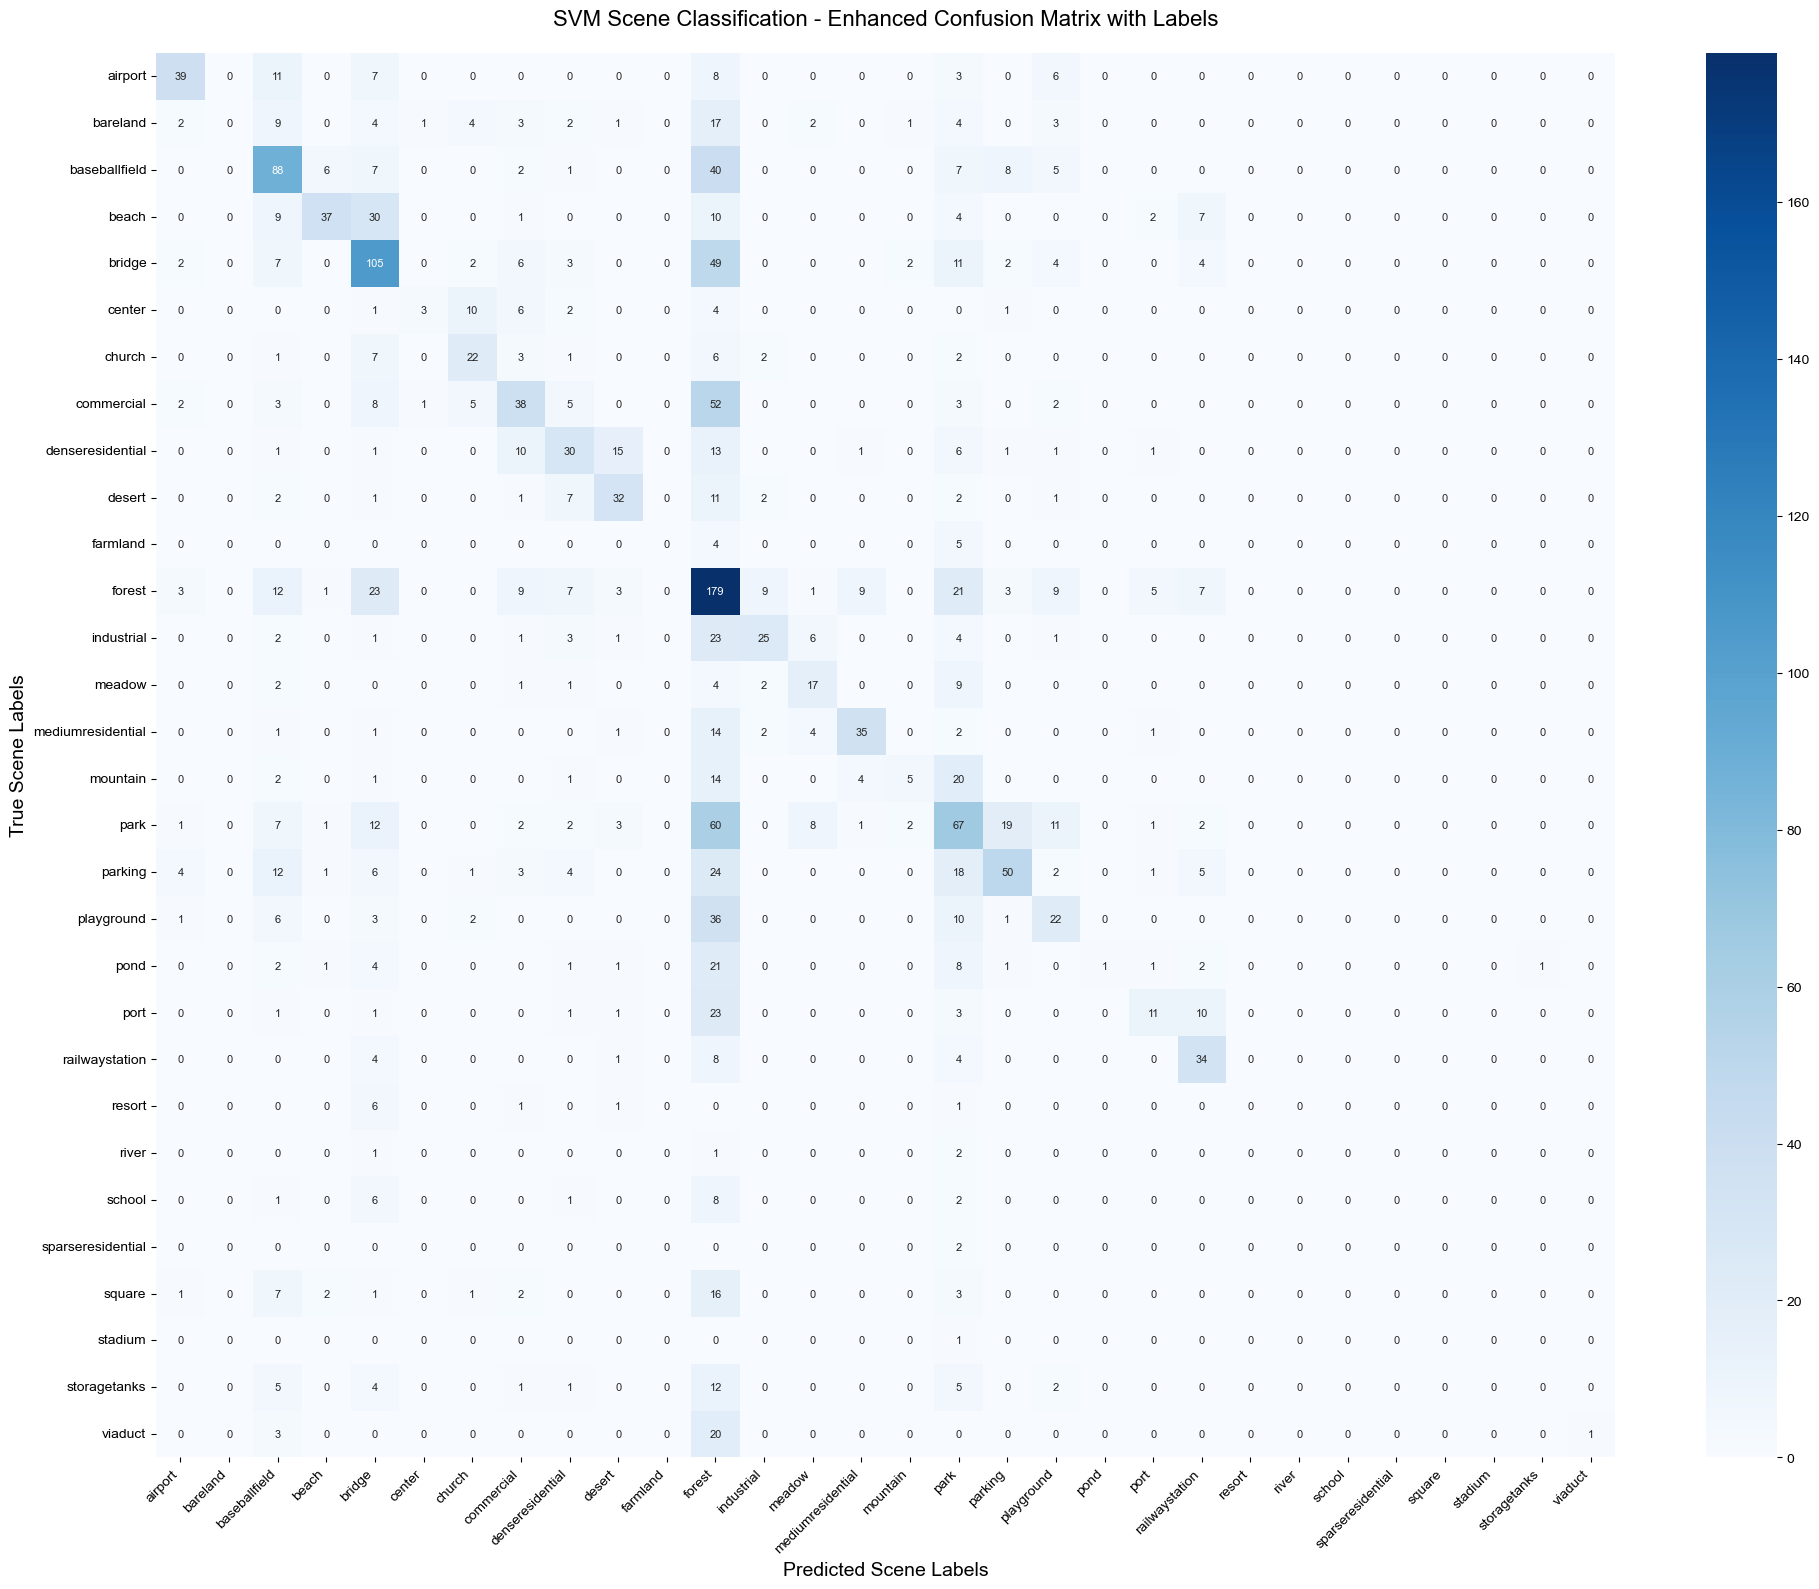

Enhanced confusion matrix visualization completed!

=== Confusion Matrix Statistics ===
Total correct predictions: 841
Total predictions: 2116
Overall accuracy: 0.3974

=== Most Confused Categories Analysis ===
Top 15 most confused category pairs:
Rank True Label           Predicted As         Count  Percentage
----------------------------------------------------------------------
1    park                 forest               60     2.84      %
2    commercial           forest               52     2.46      %
3    bridge               forest               49     2.32      %
4    baseballfield        forest               40     1.89      %
5    playground           forest               36     1.70      %
6    beach                bridge               30     1.42      %
7    parking              forest               24     1.13      %
8    forest               bridge               23     1.09      %
9    industrial           forest               23     1.09      %
10   port             

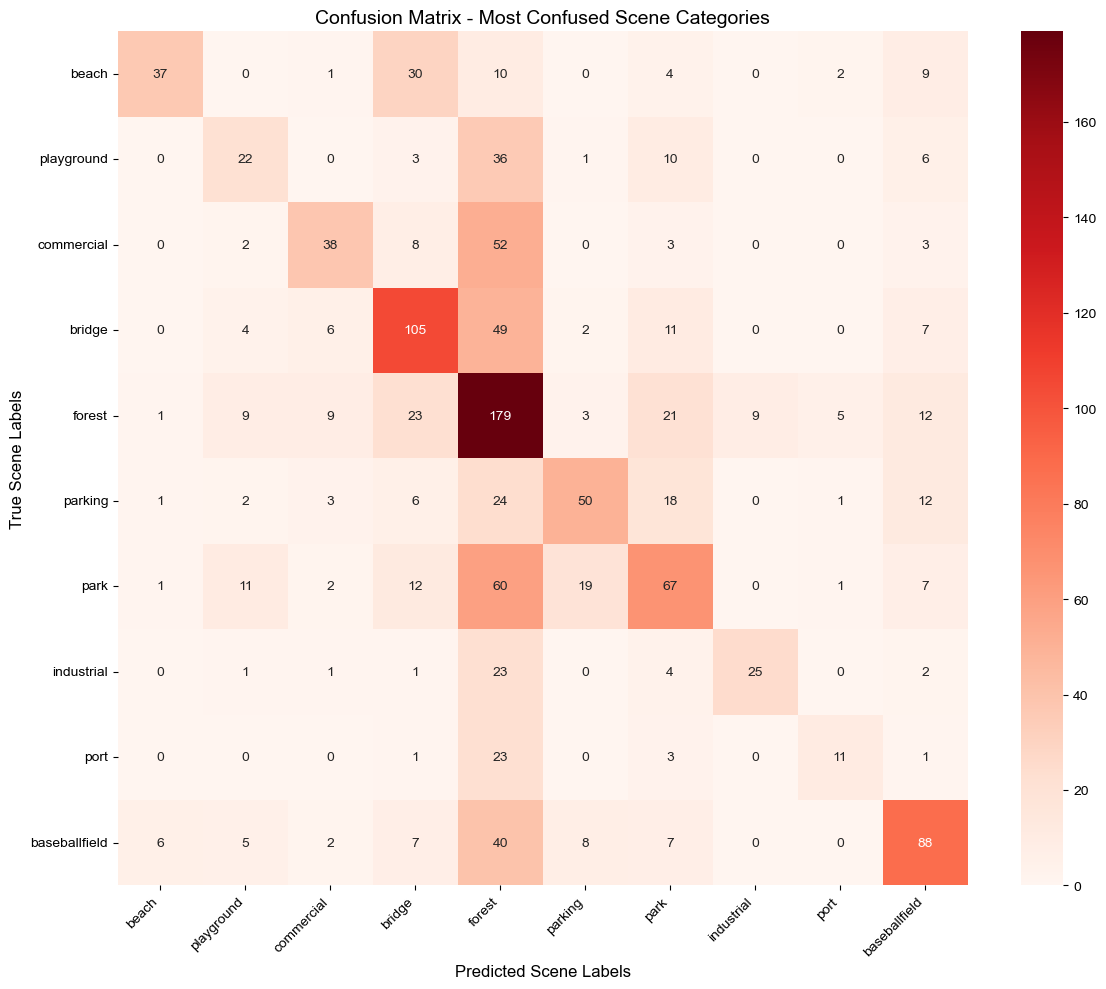

In [19]:
def create_enhanced_confusion_matrix(y_test, y_pred, title="Enhanced Confusion Matrix - SVM Scene Classification"):
    """Create enhanced confusion matrix visualization with detailed analysis"""
    print("=== Enhanced Confusion Matrix Analysis ===")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Get unique labels
    unique_labels = sorted(set(y_test))
    
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"Test set samples: {len(y_test)}")
    print(f"Number of unique labels: {len(unique_labels)}")
    print(f"Scene categories: {unique_labels}")
    
    # Create large confusion matrix visualization with labels
    plt.figure(figsize=(20, 16))
    
    # Create confusion matrix with all labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels,
                annot_kws={'size': 8})
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Predicted Scene Labels', fontsize=14)
    plt.ylabel('True Scene Labels', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    print("Enhanced confusion matrix visualization completed!")
    
    # Additional analysis
    print(f"\n=== Confusion Matrix Statistics ===")
    print(f"Total correct predictions: {np.trace(cm)}")
    print(f"Total predictions: {cm.sum()}")
    print(f"Overall accuracy: {np.trace(cm) / cm.sum():.4f}")
    
    # Find most confused categories
    print(f"\n=== Most Confused Categories Analysis ===")
    confusion_pairs = []
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((unique_labels[i], unique_labels[j], cm[i, j]))
    
    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("Top 15 most confused category pairs:")
    print(f"{'Rank':<4} {'True Label':<20} {'Predicted As':<20} {'Count':<6} {'Percentage':<10}")
    print("-" * 70)
    
    for i, (true_label, pred_label, count) in enumerate(confusion_pairs[:15]):
        percentage = (count / len(y_test)) * 100
        print(f"{i+1:<4} {true_label:<20} {pred_label:<20} {count:<6} {percentage:<10.2f}%")
    
    # Create a smaller confusion matrix for most confused pairs
    if len(confusion_pairs) > 0:
        print("\n=== Visualization of Most Confused Categories ===")
        
        # Get top confused categories
        top_confused = list(set([pair[0] for pair in confusion_pairs[:10]] + [pair[1] for pair in confusion_pairs[:10]]))
        
        # Create indices for these categories
        confused_indices = [unique_labels.index(label) for label in top_confused if label in unique_labels]
        
        # Extract submatrix
        cm_subset = cm[np.ix_(confused_indices, confused_indices)]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Reds', 
                    xticklabels=[unique_labels[i] for i in confused_indices], 
                    yticklabels=[unique_labels[i] for i in confused_indices],
                    annot_kws={'size': 10})
        plt.title('Confusion Matrix - Most Confused Scene Categories', fontsize=14)
        plt.xlabel('Predicted Scene Labels', fontsize=12)
        plt.ylabel('True Scene Labels', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return cm, unique_labels, confusion_pairs

# Create the enhanced confusion matrix
cm_enhanced, unique_labels_enhanced, confusion_pairs = create_enhanced_confusion_matrix(
    y_test, y_pred_best, 
    title="SVM Scene Classification - Enhanced Confusion Matrix with Labels"
)


In [20]:
## 13. Confusion Matrix Analysis Summary


In [21]:
# Detailed analysis of confusion matrix results
print("=" * 80)
print("                    CONFUSION MATRIX ANALYSIS SUMMARY")
print("=" * 80)

# Overall performance metrics
accuracy = np.trace(cm_enhanced) / cm_enhanced.sum()
print(f"\n📊 Overall Performance:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Total samples: {len(y_test)}")
print(f"   Correct predictions: {np.trace(cm_enhanced)}")
print(f"   Incorrect predictions: {cm_enhanced.sum() - np.trace(cm_enhanced)}")

# Per-category performance analysis
print(f"\n📈 Per-Category Performance Analysis:")
print(f"{'Scene Category':<20} {'Samples':<8} {'Correct':<8} {'Accuracy':<10} {'Main Confusion':<20}")
print("-" * 80)

for i, label in enumerate(unique_labels_enhanced):
    correct = cm_enhanced[i, i]
    total_samples = cm_enhanced[i, :].sum()
    category_accuracy = correct / total_samples if total_samples > 0 else 0
    
    # Find main confusion (most common wrong prediction)
    wrong_predictions = cm_enhanced[i, :].copy()
    wrong_predictions[i] = 0  # Remove correct predictions
    if wrong_predictions.sum() > 0:
        main_confusion_idx = np.argmax(wrong_predictions)
        main_confusion = f"{unique_labels_enhanced[main_confusion_idx]} ({wrong_predictions[main_confusion_idx]})"
    else:
        main_confusion = "None"
    
    print(f"{label:<20} {total_samples:<8} {correct:<8} {category_accuracy:<10.3f} {main_confusion:<20}")

# Best and worst performing categories
print(f"\n🏆 Best Performing Categories:")
best_categories = []
for i, label in enumerate(unique_labels_enhanced):
    correct = cm_enhanced[i, i]
    total_samples = cm_enhanced[i, :].sum()
    if total_samples > 0:
        accuracy = correct / total_samples
        best_categories.append((label, accuracy, correct, total_samples))

best_categories.sort(key=lambda x: x[1], reverse=True)
for i, (label, acc, correct, total) in enumerate(best_categories[:5]):
    print(f"   {i+1}. {label}: {acc:.3f} ({correct}/{total})")

print(f"\n⚠️  Worst Performing Categories:")
worst_categories = [(label, acc, correct, total) for label, acc, correct, total in best_categories if total >= 10]
worst_categories.sort(key=lambda x: x[1])
for i, (label, acc, correct, total) in enumerate(worst_categories[:5]):
    print(f"   {i+1}. {label}: {acc:.3f} ({correct}/{total})")

# Most confused pairs analysis
print(f"\n🔍 Most Confused Category Pairs:")
if confusion_pairs:
    print("Top 10 confusion patterns:")
    for i, (true_label, pred_label, count) in enumerate(confusion_pairs[:10]):
        percentage = (count / len(y_test)) * 100
        print(f"   {i+1:2d}. {true_label} → {pred_label}: {count} cases ({percentage:.2f}%)")

# Data imbalance analysis
print(f"\n⚖️  Data Imbalance Analysis:")
category_counts = [cm_enhanced[i, :].sum() for i in range(len(unique_labels_enhanced))]
max_count = max(category_counts)
min_count = min(category_counts)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"   Maximum samples per category: {max_count}")
print(f"   Minimum samples per category: {min_count}")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 10:
    print("   ⚠️  Severe data imbalance detected!")
elif imbalance_ratio > 5:
    print("   ⚠️  Moderate data imbalance detected")
elif imbalance_ratio > 2:
    print("   ⚠️  Mild data imbalance detected")
else:
    print("   ✅ Data is relatively balanced")

# Recommendations
print(f"\n💡 Recommendations for Improvement:")
if accuracy < 0.5:
    print("   1. Consider using more sophisticated feature engineering")
    print("   2. Try ensemble methods (Random Forest, Gradient Boosting)")
    print("   3. Increase training data or use data augmentation")

if imbalance_ratio > 5:
    print("   4. Use class weights to handle imbalanced data")
    print("   5. Consider SMOTE or other resampling techniques")

if len(confusion_pairs) > 0 and confusion_pairs[0][2] > 20:
    print(f"   6. Focus on distinguishing between '{confusion_pairs[0][0]}' and '{confusion_pairs[0][1]}'")
    print("   7. Consider creating hierarchical classification")

print("   8. Try different kernel functions or hyperparameter tuning")
print("   9. Consider using deep learning approaches for better feature learning")

print("\n" + "=" * 80)
print("Confusion matrix analysis completed!")
print("=" * 80)


                    CONFUSION MATRIX ANALYSIS SUMMARY

📊 Overall Performance:
   Accuracy: 0.3974 (39.74%)
   Total samples: 2116
   Correct predictions: 841
   Incorrect predictions: 1275

📈 Per-Category Performance Analysis:
Scene Category       Samples  Correct  Accuracy   Main Confusion      
--------------------------------------------------------------------------------
airport              74       39       0.527      baseballfield (11)  
bareland             53       0        0.000      forest (17)         
baseballfield        164      88       0.537      forest (40)         
beach                100      37       0.370      bridge (30)         
bridge               197      105      0.533      forest (49)         
center               27       3        0.111      church (10)         
church               44       22       0.500      bridge (7)          
commercial           119      38       0.319      forest (52)         
denseresidential     80       30       0.375      des

In [ ]:
## 14. Final Summary

The enhanced confusion matrix analysis provides detailed insights into the SVM model's performance:

1. **Overall Performance**: Shows the model's accuracy and prediction statistics
2. **Per-Category Analysis**: Detailed breakdown of each scene category's performance
3. **Confusion Patterns**: Identifies which categories are most commonly confused
4. **Data Imbalance**: Analyzes the distribution of samples across categories
5. **Improvement Recommendations**: Provides actionable suggestions for model enhancement

The confusion matrix visualization with scene labels makes it easy to:
- Identify which scene types are well-classified
- Spot problematic classification patterns
- Understand the model's strengths and weaknesses
- Make informed decisions about model improvements
